# Example 20 - Sill

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 1381 m wide (W-E extent) and 1768 m high (N-S extent). The model represents a wedge shaped sill that was encountered in boreholes. 

The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example20.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded from an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example20/'
gg.download_gemgis_data.download_tutorial_data(filename="example20_sill.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by creating a NumPy array containing the height values. For this example, the height is 0, meaning that a flat topography at sea level is present. 

<img src="../images/dem_example20.png" width="800">

### Creating the raster

In [4]:
import numpy as np
topo_raster = np.zeros((138, 176))

### Plotting the raster

Text(0, 0.5, 'Y [m]')

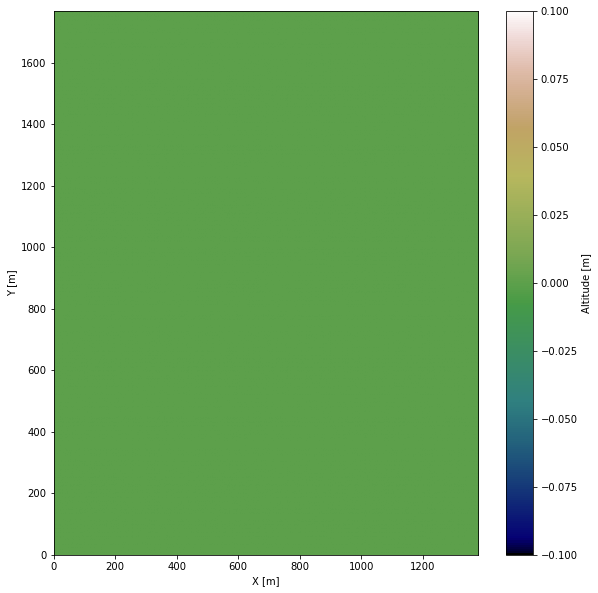

In [5]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, figsize=(10,10))
im = plt.imshow(topo_raster, origin='lower', extent=[0,1381,0,1768], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [6]:
topo_raster = rasterio.open(file_path + 'raster20.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example10.png" width="800">

In [7]:
interfaces = gpd.read_file(file_path + 'interfaces20.shp')
interfaces.head()

id formation    Z                  geometry
0  None      Base  -80   POINT (311.718 603.282)
1  None      Base -120   POINT (993.233 130.266)
2  None       Top  -50  POINT (1052.804 601.233)
3  None      Base -200  POINT (1052.804 601.233)
4  None       Top -100   POINT (399.981 974.235)

### Extracting Z coordinate from Digital Elevation Model

In [8]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=None)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords = interfaces_coords[interfaces_coords['formation'].isin(['Base', 'Top'])]
interfaces_coords.head()

formation       Z                   geometry       X       Y
2       Top  -50.00   POINT (1052.804 601.233) 1052.80  601.23
4       Top -100.00    POINT (399.981 974.235)  399.98  974.24
6       Top -300.00  POINT (1324.290 1301.740) 1324.29 1301.74
8       Top -350.00  POINT (1213.755 1499.718) 1213.76 1499.72
0      Base  -80.00    POINT (311.718 603.282)  311.72  603.28

### Plotting the Interface Points

Text(131.5312481293027, 0.5, 'Y [m]')

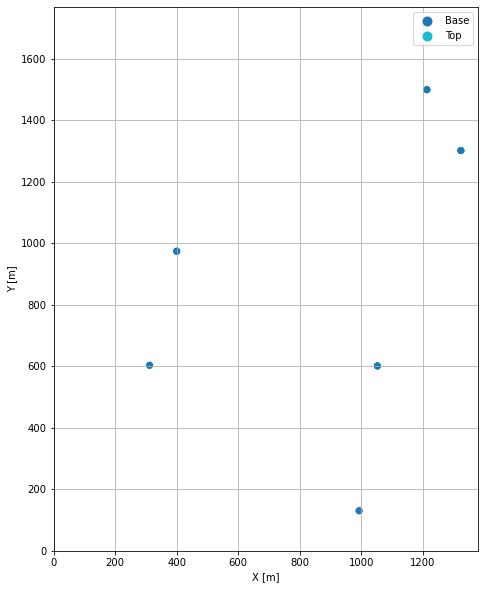

In [9]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlim(0,1381)
plt.ylim(0,1768)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Borehole Observations

Orientations of the sill will be calculated as it was a three point problem with `calculate_orientation_for_three_point_problem()`.

<img src="../images/orientations_example20.png" width="800">

In [10]:
interfaces

id formation    Z                   geometry
0  None      Base  -80    POINT (311.718 603.282)
1  None      Base -120    POINT (993.233 130.266)
2  None       Top  -50   POINT (1052.804 601.233)
3  None      Base -200   POINT (1052.804 601.233)
4  None       Top -100    POINT (399.981 974.235)
5  None      Base -150    POINT (399.981 974.235)
6  None       Top -300  POINT (1324.290 1301.740)
7  None      Base -350  POINT (1324.290 1301.740)
8  None       Top -350  POINT (1213.755 1499.718)
9  None      Base -360  POINT (1213.755 1499.718)

### Calculate Orientations for each formation

In [11]:
interfaces_base = interfaces[interfaces['formation']=='Base'].reset_index()
interfaces_base

index    id formation    Z                   geometry
0      0  None      Base  -80    POINT (311.718 603.282)
1      1  None      Base -120    POINT (993.233 130.266)
2      3  None      Base -200   POINT (1052.804 601.233)
3      5  None      Base -150    POINT (399.981 974.235)
4      7  None      Base -350  POINT (1324.290 1301.740)
5      9  None      Base -360  POINT (1213.755 1499.718)

In [12]:
orientations1 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_base.loc[:2])
orientations1['Z'] = orientations1['Z'].astype(float)
orientations1['azimuth'] = orientations1['azimuth'].astype(float)
orientations1['dip'] = orientations1['dip'].astype(float)
orientations1['dip'] = 180 - orientations1['dip']
orientations1['azimuth'] = 180 - orientations1['azimuth']
orientations1['polarity'] = orientations1['polarity'].astype(float)
orientations1['X'] = orientations1['X'].astype(float)
orientations1['Y'] = orientations1['Y'].astype(float)
orientations1

Z formation  azimuth   dip  polarity      X      Y  \
0 -133.33      Base   312.61 12.44      1.00 785.92 444.93   

                  geometry  
0  POINT (785.918 444.927)

In [13]:
orientations2 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_base.loc[1:3])
orientations2['azimuth'] = 360-orientations2['azimuth']
orientations2

Z formation azimuth   dip polarity      X      Y  \
0 -156.67      Base  312.69 12.42        1 815.34 568.58   

                  geometry  
0  POINT (815.339 568.578)

In [14]:
orientations3 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_base.loc[2:4])
orientations3['Z'] = orientations3['Z'].astype(float)
orientations3['azimuth'] = orientations3['azimuth'].astype(float)
orientations3['dip'] = orientations3['dip'].astype(float)
orientations3['dip'] = 180 - orientations3['dip']
orientations3['azimuth'] = 180 - orientations3['azimuth']
orientations3['polarity'] = orientations3['polarity'].astype(float)
orientations3['X'] = orientations3['X'].astype(float)
orientations3['Y'] = orientations3['Y'].astype(float)
orientations3

Z formation  azimuth   dip  polarity      X      Y  \
0 -233.33      Base   312.84 12.52      1.00 925.69 959.07   

                  geometry  
0  POINT (925.692 959.069)

In [15]:
orientations4 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_base.loc[3:5])
orientations4['Z'] = orientations4['Z'].astype(float)
orientations4['azimuth'] = orientations4['azimuth'].astype(float)
orientations4['dip'] = orientations4['dip'].astype(float)
orientations4['dip'] = 180 - orientations4['dip']
orientations4['azimuth'] = 180 - orientations4['azimuth']
orientations4['polarity'] = orientations4['polarity'].astype(float)
orientations4['X'] = orientations4['X'].astype(float)
orientations4['Y'] = orientations4['Y'].astype(float)
orientations4

Z formation  azimuth   dip  polarity      X       Y  \
0 -286.67      Base   310.80 12.35      1.00 979.34 1258.56   

                   geometry  
0  POINT (979.342 1258.564)

In [16]:
interfaces_top = interfaces[interfaces['formation']=='Top'].reset_index()
interfaces_top

index    id formation    Z                   geometry
0      2  None       Top  -50   POINT (1052.804 601.233)
1      4  None       Top -100    POINT (399.981 974.235)
2      6  None       Top -300  POINT (1324.290 1301.740)
3      8  None       Top -350  POINT (1213.755 1499.718)

In [17]:
orientations5 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_top.loc[0:2])
orientations5['azimuth'] = 360 - orientations5['azimuth']
orientations5

Z formation azimuth   dip polarity      X      Y  \
0 -150.0       Top  341.77 18.43        1 925.69 959.07   

                  geometry  
0  POINT (925.692 959.069)

In [18]:
orientations6 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_top.loc[1:3])
orientations6['azimuth'] = 180 - orientations6['azimuth']
orientations6['dip'] = 180 - orientations6['dip']
orientations6

Z formation azimuth   dip polarity      X       Y  \
0 -250.0       Top  341.23 18.22        1 979.34 1258.56   

                   geometry  
0  POINT (979.342 1258.564)

In [19]:
orientations7 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_top.loc[[0,2,3]])
orientations7['azimuth'] = 180 - orientations7['azimuth']
orientations7['dip'] = 180 - orientations7['dip']
orientations7

Z formation azimuth   dip polarity       X       Y  \
0 -233.33       Top  340.65 18.41        1 1196.95 1134.23   

                    geometry  
0  POINT (1196.950 1134.230)

In [20]:
orientations8 = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces_top.loc[[0,1,3]])
orientations8['azimuth'] = 360 - orientations8['azimuth']
orientations8

Z formation azimuth   dip polarity      X       Y  \
0 -166.67       Top  341.82 18.36        1 888.85 1025.06   

                   geometry  
0  POINT (888.847 1025.062)

### Merging Orientations

In [21]:
import pandas as pd
orientations = pd.concat([orientations1, orientations2, orientations3, orientations4, orientations5, orientations6, orientations7, orientations8]).reset_index()
orientations = orientations[orientations['formation'].isin(['Base', 'Top'])]
orientations['Z'] = orientations['Z'].astype(float)
orientations['azimuth'] = orientations['azimuth'].astype(float)
orientations['dip'] = orientations['dip'].astype(float)
orientations['polarity'] = orientations['polarity'].astype(float)
orientations['X'] = orientations['X'].astype(float)
orientations['Y'] = orientations['Y'].astype(float)
orientations

index       Z formation  azimuth   dip  polarity       X       Y  \
0      0 -133.33      Base   312.61 12.44      1.00  785.92  444.93   
1      0 -156.67      Base   312.69 12.42      1.00  815.34  568.58   
2      0 -233.33      Base   312.84 12.52      1.00  925.69  959.07   
3      0 -286.67      Base   310.80 12.35      1.00  979.34 1258.56   
4      0 -150.00       Top   341.77 18.43      1.00  925.69  959.07   
5      0 -250.00       Top   341.23 18.22      1.00  979.34 1258.56   
6      0 -233.33       Top   340.65 18.41      1.00 1196.95 1134.23   
7      0 -166.67       Top   341.82 18.36      1.00  888.85 1025.06   

                    geometry  
0    POINT (785.918 444.927)  
1    POINT (815.339 568.578)  
2    POINT (925.692 959.069)  
3   POINT (979.342 1258.564)  
4    POINT (925.692 959.069)  
5   POINT (979.342 1258.564)  
6  POINT (1196.950 1134.230)  
7   POINT (888.847 1025.062)

### Plotting the Orientations

Text(131.5312481293027, 0.5, 'Y [m]')

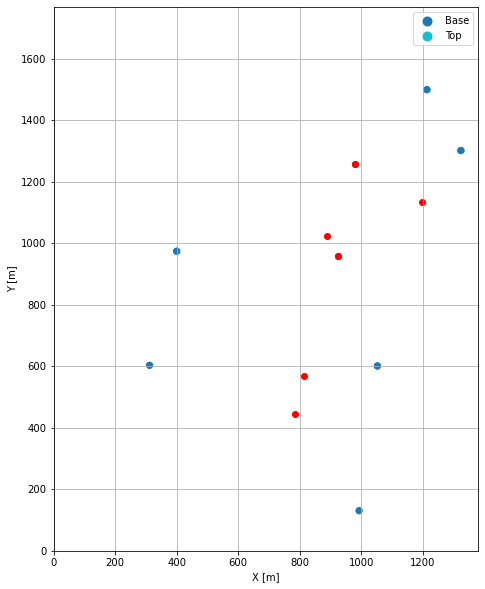

In [22]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlim(0,1381)
plt.ylim(0,1768)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [23]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [24]:
geo_model = gp.create_model('Model20')
geo_model

Model20  2021-04-05 10:41

### Initiate Data

In [25]:
gp.init_data(geo_model, [0,1381,0,1768,-500,250], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model20  2021-04-05 10:41

### Model Surfaces

In [26]:
geo_model.surfaces

surface          series  order_surfaces    color  id
0     Top  Default series               1  #015482   1
1    Base  Default series               2  #9f0052   2

### Mapping the Stack to Surfaces

In [27]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Top'),   
                          'Strata2': ('Base'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

surface   series  order_surfaces    color  id
0       Top  Strata1               1  #015482   1
1      Base  Strata2               1  #9f0052   2
2  Basement  Strata2               2  #ffbe00   3

### Showing the Number of Data Points

In [28]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

surface   series  order_surfaces    color  id  No. of Interfaces  No. of Orientations
0       Top  Strata1               1  #015482   1                  4                    4
1      Base  Strata2               1  #9f0052   2                  6                    4
2  Basement  Strata2               2  #ffbe00   3                  0                    0

### Loading Digital Elevation Model

In [29]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster20.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   6.905     ,    8.84      , -496.25      ],
       [   6.905     ,    8.84      , -488.75      ],
       [   6.905     ,    8.84      , -481.25      ],
       ...,
       [1377.07670455, 1735.97101449,    0.        ],
       [1377.07670455, 1748.7826087 ,    0.        ],
       [1377.07670455, 1761.5942029 ,    0.        ]])

### Plotting Input Data

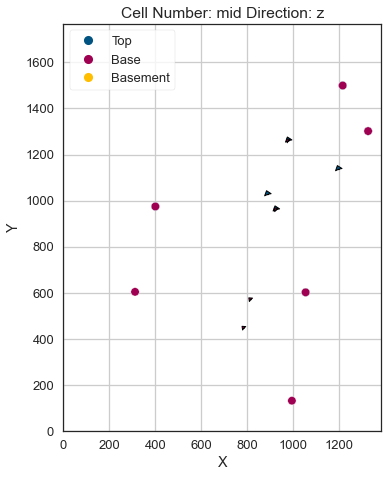

In [30]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

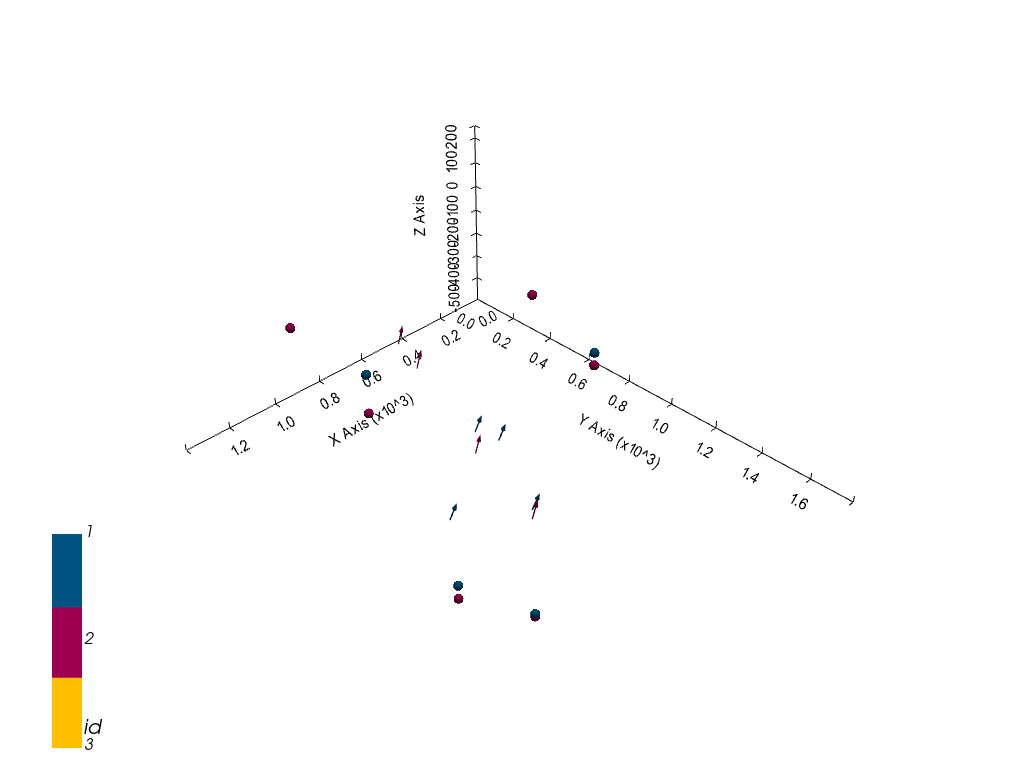

In [31]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [32]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             2365.48
$C_o$           133225.83
drift equations    [3, 3]


### Computing Model

In [33]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

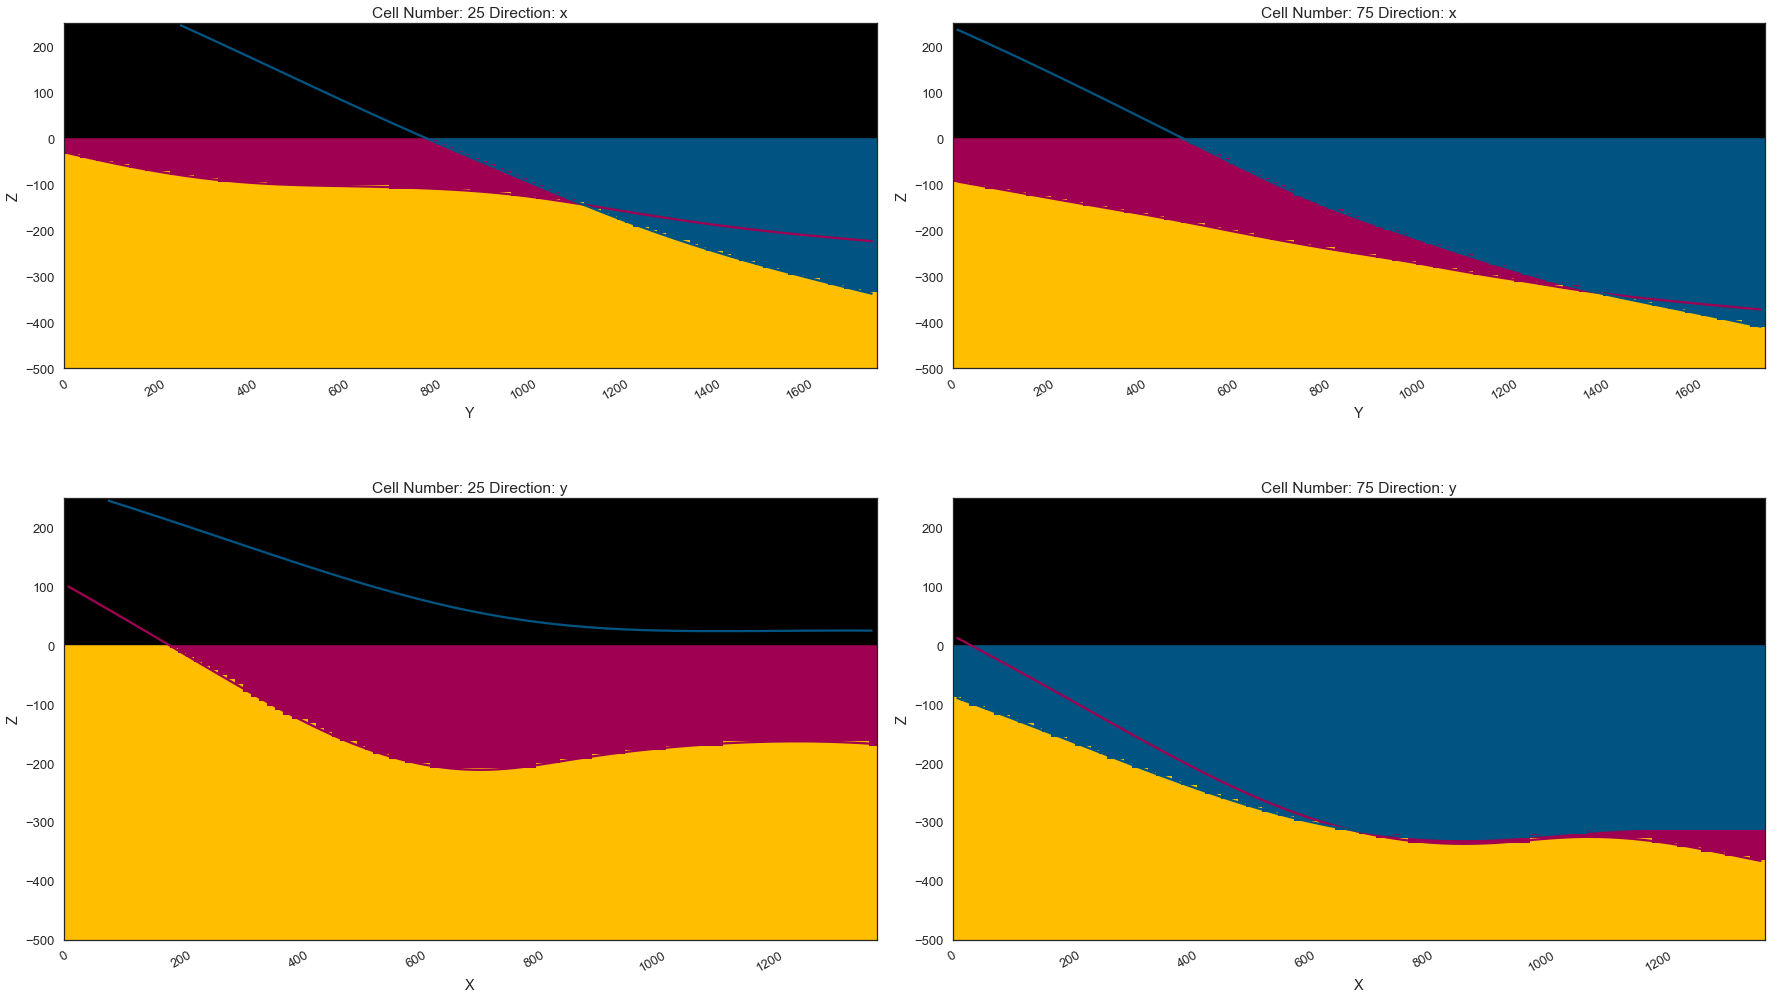

In [34]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

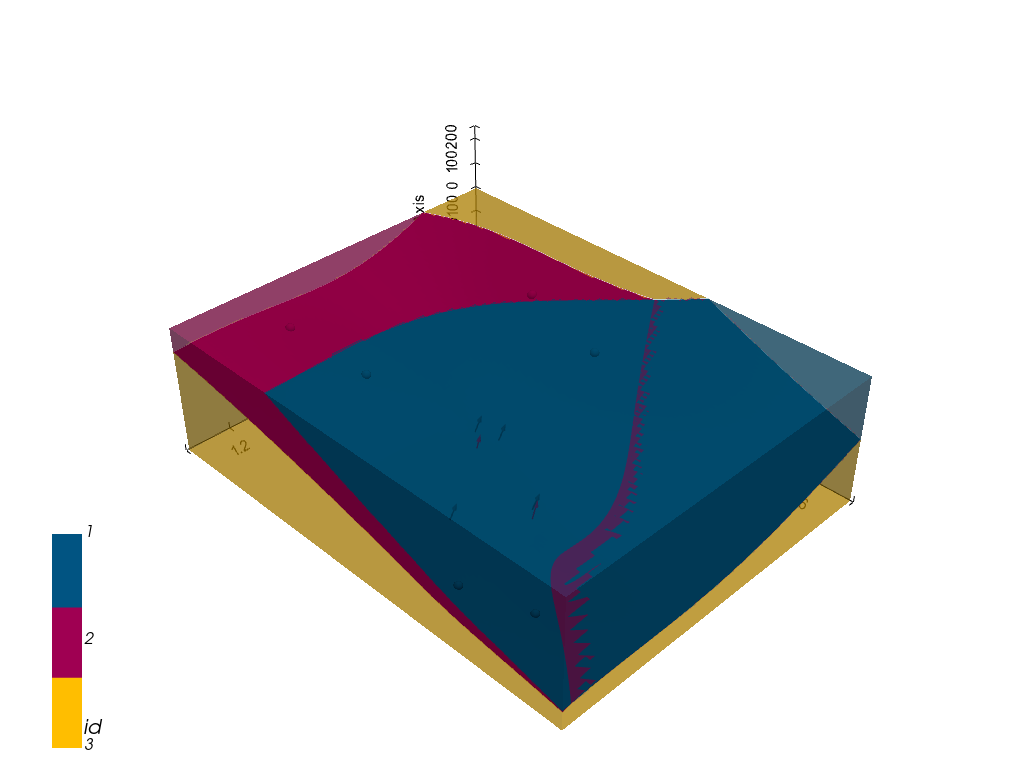

In [35]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=False,
                 plotter_type='basic', notebook=True, show_lith=True)